In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32

common_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Simple normalization for now
])


In [3]:
from torchvision import datasets, transforms
import os

# Correct subfolder paths
pneumonia_train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
pneumonia_val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
pneumonia_test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

# Common transforms
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load datasets
pneumonia_train = datasets.ImageFolder(
    root=pneumonia_train_dir,
    transform=common_transforms,
    is_valid_file=lambda path: not os.path.basename(path).startswith("._")
)

pneumonia_val = datasets.ImageFolder(
    root=pneumonia_val_dir,
    transform=common_transforms
)

pneumonia_test = datasets.ImageFolder(
    root=pneumonia_test_dir,
    transform=common_transforms
)

# Check classes
print("Pneumonia Classes:", pneumonia_train.classes)  # Should show ['NORMAL', 'PNEUMONIA']


Pneumonia Classes: ['NORMAL', 'PNEUMONIA']


In [4]:
def show_images(dataset, title, class_labels):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    for i, ax in enumerate(axes):
        img, label = dataset[i]
        ax.imshow(img.permute(1, 2, 0))  # From (C, H, W) to (H, W, C)
        ax.set_title(class_labels[label])
        ax.axis('off')
    plt.suptitle(title)
    plt.show()


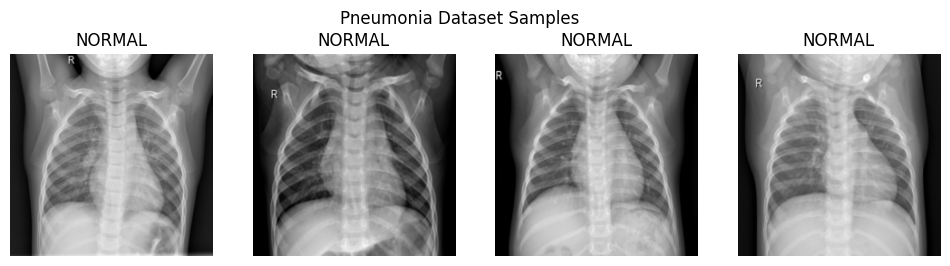

In [5]:
show_images(pneumonia_train, "Pneumonia Dataset Samples", pneumonia_train.classes)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


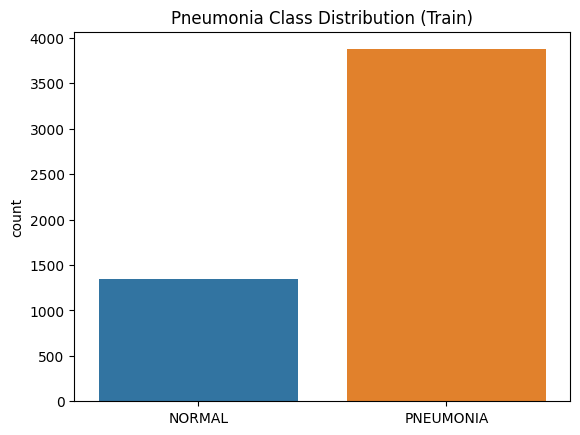

In [6]:
labels = [label for _, label in pneumonia_train]
sns.countplot(x=labels)
plt.xticks([0, 1], pneumonia_train.classes)
plt.title("Pneumonia Class Distribution (Train)")
plt.show()


In [7]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

# Image transformations
common_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Load dataset from folder containing 'yes' and 'no' subfolders
tumor_dataset = datasets.ImageFolder(
    root='/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset',
    transform=common_transforms
)

# Split into training and validation (80/20)
train_size = int(0.8 * len(tumor_dataset))
val_size = len(tumor_dataset) - train_size
tumor_train, tumor_val = random_split(tumor_dataset, [train_size, val_size])

# Print detected classes
print("Brain Tumor Classes:", tumor_dataset.classes)  # Should print: ['no', 'yes']


Brain Tumor Classes: ['no', 'yes']


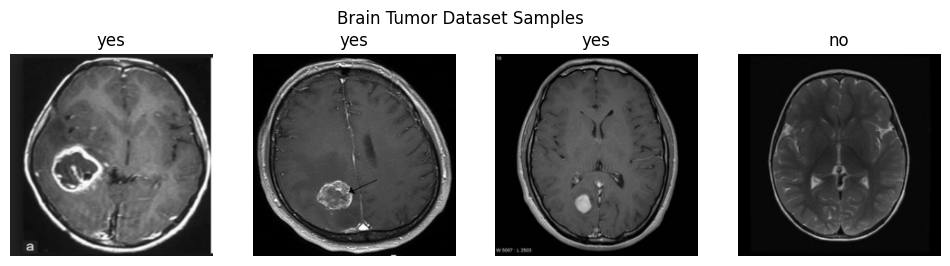

In [8]:
show_images(tumor_train, "Brain Tumor Dataset Samples", tumor_dataset.classes)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


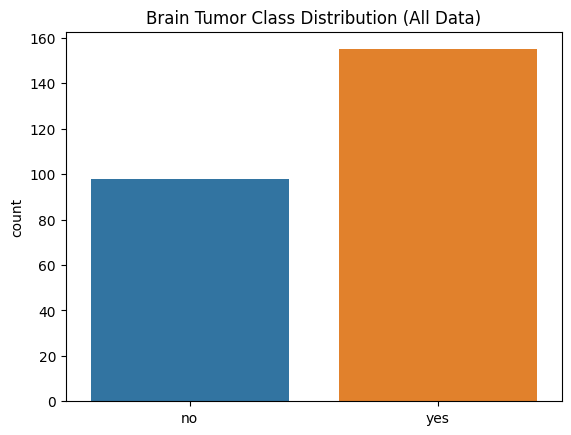

In [9]:
labels = [tumor_dataset[i][1] for i in range(len(tumor_dataset))]
sns.countplot(x=labels)
plt.xticks([0, 1], tumor_dataset.classes)
plt.title("Brain Tumor Class Distribution (All Data)")
plt.show()


In [10]:
pneumonia_train_loader = DataLoader(pneumonia_train, batch_size=BATCH_SIZE, shuffle=True)
tumor_train_loader = DataLoader(tumor_train, batch_size=BATCH_SIZE, shuffle=True)


Day 2

In [11]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        if self.best_score is None:
            self.best_score = val_accuracy
        elif val_accuracy < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_accuracy
            self.counter = 0


In [15]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import models
from torchvision.models import resnet18


def create_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model.to(device)

def train_model(model, train_loader, val_loader, epochs=5, name="model"):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                pred = output.argmax(dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)

        acc = correct / total
        val_accuracies.append(acc)
        print(f"{name} | Epoch {epoch+1}/{epochs} → Validation Accuracy: {acc*100:.2f}%")

    return model, val_accuracies


In [17]:
from torch.utils.data import DataLoader

pneumonia_val_loader = DataLoader(pneumonia_val, batch_size=32, shuffle=False)
pneumonia_model = create_model()

# Now pass the correct DataLoader
pneumonia_model, pneumonia_acc = train_model(
    pneumonia_model, 
    pneumonia_train_loader, 
    val_loader=pneumonia_val_loader, 
    epochs=5, 
    name="Pneumonia"
)


Pneumonia | Epoch 1/5 → Validation Accuracy: 56.25%
Pneumonia | Epoch 2/5 → Validation Accuracy: 75.00%
Pneumonia | Epoch 3/5 → Validation Accuracy: 75.00%
Pneumonia | Epoch 4/5 → Validation Accuracy: 68.75%
Pneumonia | Epoch 5/5 → Validation Accuracy: 75.00%


In [16]:
from torch.utils.data import DataLoader

# Create a DataLoader for tumor_val
tumor_val_loader = DataLoader(tumor_val, batch_size=32, shuffle=False)

# Then pass it properly
tumor_model = create_model()
tumor_model, tumor_acc = train_model(
    tumor_model,
    tumor_train_loader,
    val_loader=tumor_val_loader,  # <-- THIS is now fixed
    epochs=20,
    name="Tumor"
)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 143MB/s]


Tumor | Epoch 1/20 → Validation Accuracy: 58.82%
Tumor | Epoch 2/20 → Validation Accuracy: 70.59%
Tumor | Epoch 3/20 → Validation Accuracy: 64.71%
Tumor | Epoch 4/20 → Validation Accuracy: 78.43%
Tumor | Epoch 5/20 → Validation Accuracy: 70.59%
Tumor | Epoch 6/20 → Validation Accuracy: 80.39%
Tumor | Epoch 7/20 → Validation Accuracy: 80.39%
Tumor | Epoch 8/20 → Validation Accuracy: 78.43%
Tumor | Epoch 9/20 → Validation Accuracy: 84.31%
Tumor | Epoch 10/20 → Validation Accuracy: 82.35%
Tumor | Epoch 11/20 → Validation Accuracy: 80.39%
Tumor | Epoch 12/20 → Validation Accuracy: 82.35%
Tumor | Epoch 13/20 → Validation Accuracy: 78.43%
Tumor | Epoch 14/20 → Validation Accuracy: 82.35%
Tumor | Epoch 15/20 → Validation Accuracy: 82.35%
Tumor | Epoch 16/20 → Validation Accuracy: 82.35%
Tumor | Epoch 17/20 → Validation Accuracy: 82.35%
Tumor | Epoch 18/20 → Validation Accuracy: 82.35%
Tumor | Epoch 19/20 → Validation Accuracy: 82.35%
Tumor | Epoch 20/20 → Validation Accuracy: 82.35%


In [18]:
os.makedirs("../models", exist_ok=True)
torch.save(pneumonia_model.state_dict(), "/kaggle/working/pneumonia_model.pt")
torch.save(tumor_model.state_dict(), "/kaggle/working/tumor_model.pt")
print("✅ Models saved in ../models/")


✅ Models saved in ../models/


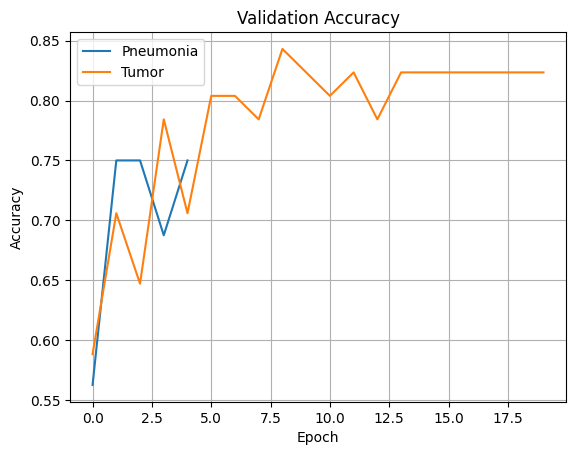

In [19]:
plt.plot(pneumonia_acc, label='Pneumonia')
plt.plot(tumor_acc, label='Tumor')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


Day 3

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns

def evaluate_model(model, test_loader, class_names, title):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            pred = output.argmax(dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"{title} Accuracy: {acc*100:.2f}%")

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title(f"{title} Confusion Matrix")
    plt.show()


Pneumonia Model Accuracy: 81.89%


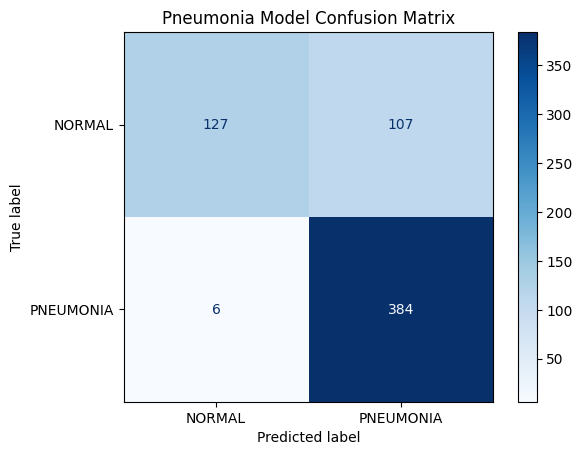

In [21]:
pneumonia_test_loader = DataLoader(pneumonia_test, batch_size=32)
evaluate_model(pneumonia_model, pneumonia_test_loader, pneumonia_train.classes, "Pneumonia Model")


Tumor Model Accuracy: 82.35%


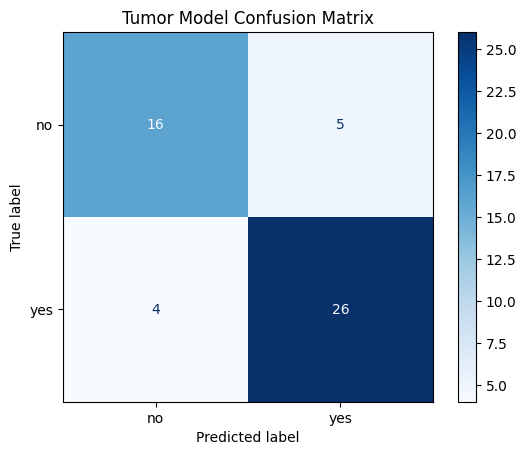

In [22]:
tumor_val_loader = DataLoader(tumor_val, batch_size=32)  # We used random_split
evaluate_model(tumor_model, tumor_val_loader, tumor_dataset.classes, "Tumor Model")


In [23]:
pip install torchcam


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvi

In [33]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchcam.methods import GradCAM

def generate_gradcam(model, image_tensor, target_layer="layer4", class_idx=None, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    model.to(device)

    # Ensure image is 4D and on device
    input_tensor = image_tensor.unsqueeze(0).to(device)
    input_tensor.requires_grad = True

    # Create Grad-CAM extractor
    cam_extractor = GradCAM(model, target_layer=target_layer)

    # Forward pass
    output = model(input_tensor)
    if class_idx is None:
        class_idx = output.argmax().item()

    # Get activation map
    activation_map = cam_extractor(class_idx, output)[0]  # shape: [1, H, W]

    # Resize activation map to match input image size
  # Resize activation map to input image size
    cam_resized = F.interpolate(activation_map.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
    cam_resized = cam_resized.squeeze().cpu().detach().numpy()


    # Convert input image for plotting
    img_np = image_tensor.permute(1, 2, 0).cpu().detach().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize to [0, 1]

    # Plot
    plt.figure(figsize=(6, 6))
    plt.imshow(img_np)
    plt.imshow(cam_resized, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM (Class {class_idx})")
    plt.axis('off')
    plt.show()


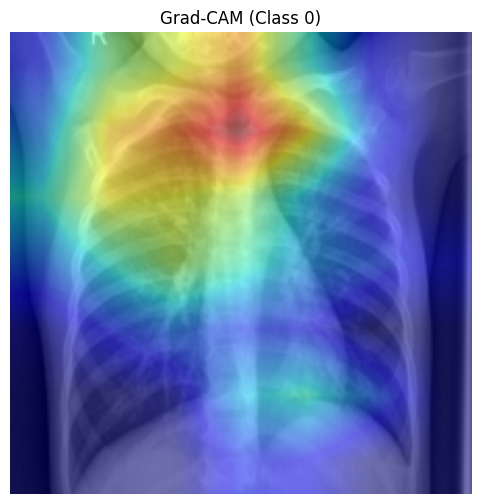

In [34]:
img, label = pneumonia_test[5]
generate_gradcam(pneumonia_model, img, target_layer="layer4", class_idx=label)


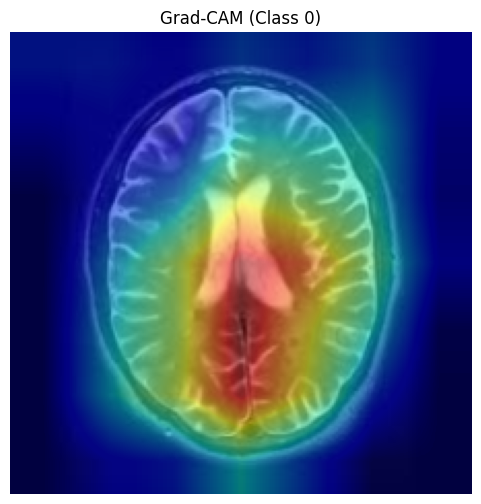

In [35]:
img, label = tumor_dataset[12]
generate_gradcam(tumor_model, img, target_layer="layer4", class_idx=label)


In [42]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchcam.methods import GradCAM

def show_multiple_gradcams(model, dataset, indices, target_layer="layer4", device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device).eval()
    cam_extractor = GradCAM(model, target_layer=target_layer)

    n = len(indices)
    fig, axes = plt.subplots(1, n, figsize=(n * 4, 4))

    for idx, ax in zip(indices, axes):
        image_tensor, label = dataset[idx]
        input_tensor = image_tensor.unsqueeze(0).to(device)
        input_tensor.requires_grad_()

        # Forward pass
        output = model(input_tensor)
        class_idx = label
        activation_map = cam_extractor(class_idx, output)[0]

        # Resize CAM to match image
        # Resize CAM to match image
        if activation_map.dim() == 3:  # shape [1, 7, 7]
            cam_resized = F.interpolate(
                activation_map.unsqueeze(0),  # → [1, 1, 7, 7]
                size=(224, 224),
                mode='bilinear',
                align_corners=False
            ).squeeze().cpu().detach().numpy()
        elif activation_map.dim() == 2:  # shape [7, 7]
            cam_resized = F.interpolate(
                activation_map.unsqueeze(0).unsqueeze(0),
                size=(224, 224),
                mode='bilinear',
                align_corners=False
            ).squeeze().cpu().detach().numpy()
        else:
            raise ValueError(f"Unexpected activation_map shape: {activation_map.shape}")


        # Normalize image
        img_np = image_tensor.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

        # Plot original + overlay
        ax.imshow(img_np)
        ax.imshow(cam_resized, cmap='jet', alpha=0.5)
        class_name = dataset.classes[label]
        ax.set_title(f"{class_name}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [48]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchcam.methods import GradCAM

def show_pneumonia_gradcams(model, dataset, target_layer="layer4", device='cuda' if torch.cuda.is_available() else 'cpu', count=3):
    model.eval().to(device)
    cam_extractor = GradCAM(model, target_layer=target_layer)

    shown = 0
    idx = 0

    plt.figure(figsize=(5 * count, 5))

    while shown < count and idx < len(dataset):
        img, label = dataset[idx]
        if label == 1:  # Only pneumonia images
            input_tensor = img.unsqueeze(0).to(device)
            input_tensor.requires_grad = True

            output = model(input_tensor)
            pred_class = output.argmax().item()

            # Get CAM
            activation_map = cam_extractor(class_idx=label, scores=output)[0]

            # Resize CAM
            cam_resized = F.interpolate(
                activation_map.unsqueeze(0),  # (1, H, W)
                size=(224, 224),
                mode='bilinear',
                align_corners=False
            ).squeeze(0).cpu().detach().numpy()

            # Normalize CAM
            cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min())

            # Prepare original image
            img_np = img.permute(1, 2, 0).cpu().numpy()
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

            ax = plt.subplot(1, count, shown + 1)
            ax.imshow(img_np)
            ax.imshow(cam_resized, cmap='jet', alpha=0.5)
            ax.set_title("Pneumonia")
            ax.axis('off')

            shown += 1


In [ ]:
show_pneumonia_gradcams(pneumonia_model, pneumonia_test, count=3)


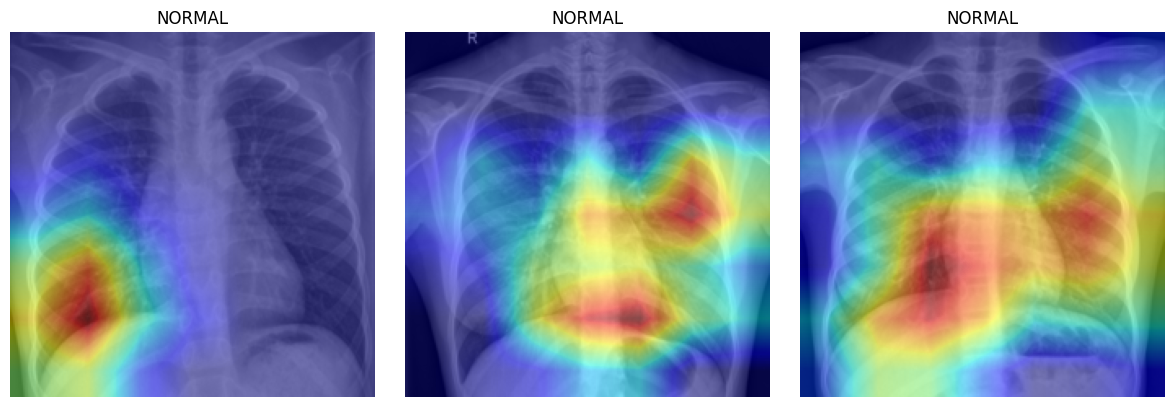

In [43]:
# Show Grad-CAMs for sample images 3, 10, and 25 from the test set
show_multiple_gradcams(pneumonia_model, pneumonia_test, indices=[3, 10, 25])

